In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
from time import time_ns
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sentencepiece as spm
import io
from dataclasses import dataclass, astuple
import gc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display, Code, clear_output

device = torch.device("cuda")
vl = {}
ls = {}
ts = {}

vocab_size = 1024

#initialize model

In [3]:
@dataclass(frozen=True, unsafe_hash=True)
class Params:
  batch_size: int
  block_size: int
  n_layer: int
  n_head: int
  dropout: float
  n_embd: int

In [4]:
class Head(nn.Module):
    def __init__(self, head_size, dropout):
        super().__init__()
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)
        # compute self-attention = QK^T / sqrt(head_size)
        # (B, T, C) @ (B, C, T) --> (B, T, T)
        wei = q @ k.mT * C**-0.5
        # drop out the forward connections
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # LT (B, T, T)
        # softmax to get multinomials
        wei = F.softmax(wei, dim=-1)

        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v # (B, T, T) @ (B, T, C) --> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, dropout) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
    def forward(self, x):
        xmean = x.mean(1, keepdim=True) # "layer" mean: across each context window
        xvar = x.var(1, keepdim=True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # zscore
        self.out = self.gamma * xhat + self.beta
        return self.out

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        head_size = n_embd // n_head
        assert(head_size * n_head == n_embd)

        self.sa = MultiHeadAttention(n_head, head_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        # residual connections by adding self
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):
    def __init__(self, params):
        super().__init__()

        # gives us token embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, params.n_embd, device=device)

        # embedding corresponding to the position of a token
        self.position_embedding_table = nn.Embedding(params.block_size, params.n_embd, device=device)

        self.blocks = nn.Sequential(
            *[Block(params.n_embd, n_head=params.n_head, dropout=params.dropout) for _ in range(n_layer)]
        )

        self.ln_f = nn.LayerNorm(params.n_embd)

        # language output
        self.lm_head = nn.Linear(params.n_embd, vocab_size)


    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (batchsize, ntoks) tensors
        # for each token, we are predicting the probabilities of the next tokens
        tok_emb = self.token_embedding_table(idx) # (batchsize, ntoks, embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (bs, embd)

        x = tok_emb + pos_emb

        # invoke self-attention
        x = self.blocks(x)
        # layernorm before logits
        x = self.ln_f(x)

        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # unpack the token predictions
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop to the last #block_size tokens
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            # look at the last time step to predict what comes next
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-08-22 22:08:11--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.20’

input.txt.20        100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2024-08-22 22:08:11 (144 MB/s) - ‘input.txt.20’ saved [1115394/1115394]



# build dataset

In [5]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(f"length = {len(text)}")
print(text[:100])
#text_bytes = text_bytes.to(device)

model = io.BytesIO()
sp = spm.SentencePieceTrainer.train(sentence_iterator=(x + '\n\n' for x in text.split('\n\n')), model_writer=model, vocab_size=vocab_size)
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())

encode = lambda x: sp.encode(x)
decode = lambda x: sp.decode(x)
encoded = sp.encode(text)

# encode entire dataset
data = torch.tensor(encoded, dtype=torch.long)
data = data.to(device)
print(data.shape, data.dtype)
print(data[:10])

# tts
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

length = 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
torch.Size([405005]) torch.int64
tensor([292, 542,   6, 226, 331,  13,  81, 227, 105,  40], device='cuda:0')


# hyperparameters

In [18]:
params = Params(
    batch_size = 16,   # minibatch
    block_size = 1024, # context
    n_layer = 4,
    n_head = 16,
    dropout = 0.4,
    n_embd = vocab_size,
)

with torch.no_grad():
  gc.collect()
  torch.cuda.empty_cache()

batch_size: int
block_size: int
n_layer: int
n_head: int
dropout: float
n_embd: int

batch_size, block_size, n_layer, n_head, dropout, n_embd = astuple(params)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,), device=device)
    x = torch.stack([data[i : i + block_size] for i in ix]).to(device)
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix]).to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model, eval_iters, splits=['val']):
    out = {}
    model.eval()
    for split in splits:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# attention

In [19]:
torch.manual_seed(1337)

m = BigramLanguageModel(params)
optimizer = torch.optim.AdamW(m.parameters(), lr=3e-4) # usually, 3e-4 but for stupid networks you can learn faster

steps = 0

m = m.to(device)
loss = (-np.log(1 / vocab_size))
print(f'expected loss given uniform output = {loss}')
print(f"n_params = {sum(p.nelement() for p in m.parameters())}")

vl[params] = [estimate_loss(m, 20)["val"]]
ls[params] = [loss.item()]
DTbar = 0.0

expected loss given uniform output = 6.931471805599453
n_params = 53521408


In [ ]:
#torch.manual_seed(9999)

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)

max_s = 15_000

log_out = display(Code(data=f"{steps:7d}/{max_s:7d}: loss={ls[params][-1]:1.4f}, valloss={vl[params][-1]:.4f}, Tavg={DTbar/1e9:.5f}", language="text"), display_id=True)
plt_out = display(fig, display_id=True)

while steps < max_s:
    steps += 1
    Ta = time_ns()

    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    DT = time_ns() - Ta
    DTbar = (DTbar*steps + DT)/(steps+1)

    ls[params].append(loss.item())
    vl[params].append(vl[params][-1])
    ts[params] = DTbar

    if steps % 10 == 0:
        if steps % 20 == 0:
          vl[params][-1] = estimate_loss(m, 1)["val"]
        ax.clear()
        ax.set_xlabel("epoch")
        ax.set_ylabel(r"$ -\log (p) $")
        ax.set_yscale("log")
        ax.plot((np.convolve(ls[params], np.ones(5) / 5.0, mode='valid')), label='train')
        ax.plot((np.convolve(vl[params], np.ones(5) / 5.0, mode='valid')), label='val')
        ax.legend()
        ax.set_title(f"batch={batch_size} ctx={block_size} depth={n_layer} heads={n_head} dropout={dropout}")
        plt_out.update(fig)
    log_out.update(Code(data=f"{steps:7d}/{max_s:7d}: loss={ls[params][-1]:1.4f}, valloss={vl[params][-1]:.4f}, Tavg={DTbar/1e9:.5f}", language="text"))


log_out.update(Code(data=f"{steps:7d}/{max_s:7d}: loss={ls[params][-1]:1.4f}, valloss={vl[params][-1]:.4f}, Tavg={DTbar/1e9:.5f}", language="text"))

# hyperparameter search

In [ ]:
fig = plt.figure(figsize=(15, 7));
ax = fig.add_subplot(1, 1, 1);
max_s = 300

dropout = 0.2
batch_size = 16    # minibatch
block_size = 1024  # ctx

all_params = [
    Params(
        batch_size = batch_size,
        block_size = block_size,
        n_layer = 18,
        n_head = 4,
        dropout = dropout,
        n_embd = vocab_size,
    ),
    Params(
        batch_size = batch_size,
        block_size = block_size,
        n_layer = 12,
        n_head = 4,
        dropout = dropout,
        n_embd = vocab_size,
    ),
    Params(
        batch_size = batch_size,
        block_size = block_size,
        n_layer = 6,
        n_head = 4,
        dropout = dropout,
        n_embd = vocab_size,
    ),
    Params(
        batch_size = batch_size,
        block_size = block_size,
        n_layer = 8,
        n_head = 4,
        dropout = dropout,
        n_embd = vocab_size,
    ),
    Params(
        batch_size = batch_size,
        block_size = block_size,
        n_layer = 8,
        n_head = 8,
        dropout = dropout,
        n_embd = vocab_size,
    ),
    Params(
        batch_size = batch_size,
        block_size = block_size,
        n_layer = 4,
        n_head = 16,
        dropout = dropout,
        n_embd = vocab_size,
    ),
]

expected loss given uniform output = 6.931471805599453
n_params = 229825536


42/    300: loss=5.8110, valloss=5.8545, Tavg=1.17410

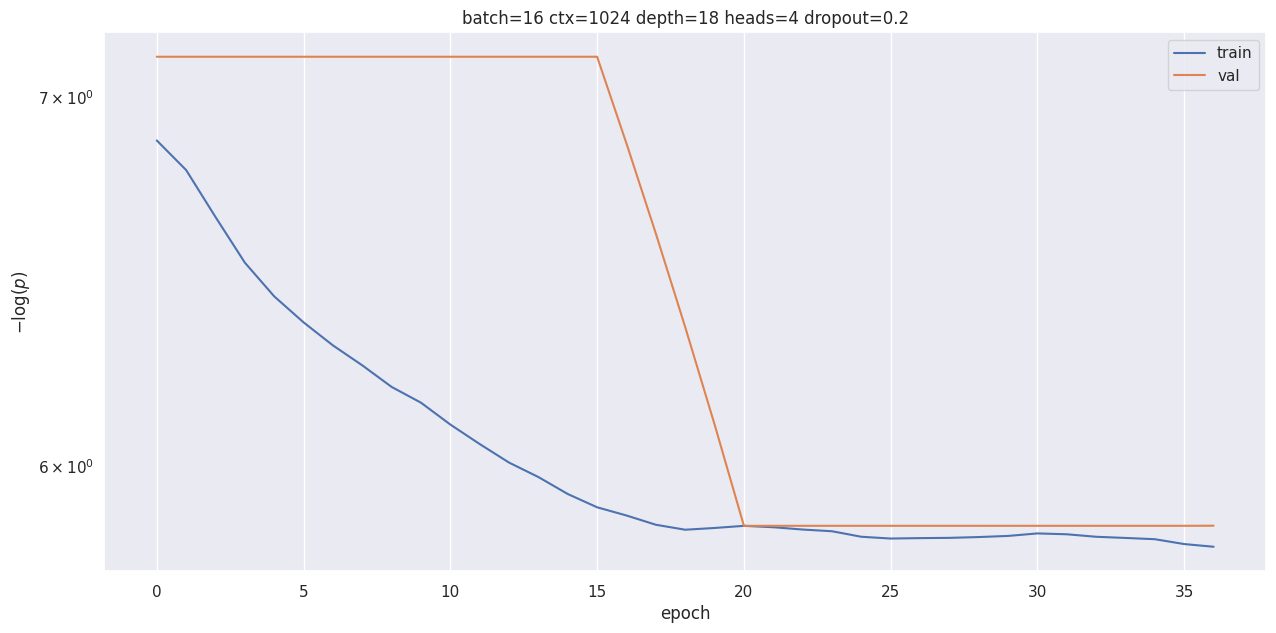

In [ ]:
for params in all_params:

  with torch.no_grad():
    gc.collect()
    torch.cuda.empty_cache()

  batch_size: int
  block_size: int
  n_layer: int
  n_head: int
  dropout: float
  n_embd: int

  batch_size, block_size, n_layer, n_head, dropout, n_embd = astuple(params)

  def get_batch(split):
      data = train_data if split == 'train' else val_data
      ix = torch.randint(len(data) - block_size, (batch_size,), device=device)
      x = torch.stack([data[i : i + block_size] for i in ix]).to(device)
      y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix]).to(device)
      return x, y

  @torch.no_grad()
  def estimate_loss(model, eval_iters, splits=['val']):
      out = {}
      model.eval()
      for split in splits:
          losses = torch.zeros(eval_iters)
          for k in range(eval_iters):
              X, Y = get_batch(split)
              logits, loss = model(X, Y)
              losses[k] = loss.item()
          out[split] = losses.mean()
      model.train()
      return out

  torch.manual_seed(1337)

  m = BigramLanguageModel(params)
  optimizer = torch.optim.AdamW(m.parameters(), lr=3e-4) # usually, 3e-4 but for stupid networks you can learn faster

  steps = 0

  m = m.to(device)
  loss = (-np.log(1 / vocab_size))
  print(f'expected loss given uniform output = {loss}')
  print(f"n_params = {sum(p.nelement() for p in m.parameters())}")

  vl[params] = [estimate_loss(m, 20)["val"]]
  ls[params] = [loss.item()]
  DTbar = 0.0

  log_out = display(Code(data=f"{steps:7d}/{max_s:7d}: loss={ls[params][-1]:1.4f}, valloss={vl[params][-1]:.4f}, Tavg={DTbar/1e9:.5f}", language="text"), display_id=True)
  plt_out = display(fig, display_id=True)

  while steps < max_s:
      steps += 1
      Ta = time_ns()

      xb, yb = get_batch('train')
      logits, loss = m(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

      DT = time_ns() - Ta
      DTbar = (DTbar*steps + DT)/(steps+1)

      ls[params].append(loss.item())
      vl[params].append(vl[params][-1])
      ts[params] = DTbar

      if steps % 10 == 0:
          if steps % 20 == 0:
            vl[params][-1] = estimate_loss(m, 1)["val"]
          ax.clear()
          ax.set_xlabel("epoch")
          ax.set_ylabel(r"$ -\log (p) $")
          ax.set_yscale("log")
          ax.plot((np.convolve(ls[params], np.ones(5) / 5.0, mode='valid')), label='train')
          ax.plot((np.convolve(vl[params], np.ones(5) / 5.0, mode='valid')), label='val')
          ax.legend()
          ax.set_title(f"batch={batch_size} ctx={block_size} depth={n_layer} heads={n_head} dropout={dropout}")
          plt_out.update(fig)
      log_out.update(Code(data=f"{steps:7d}/{max_s:7d}: loss={ls[params][-1]:1.4f}, valloss={vl[params][-1]:.4f}, Tavg={DTbar/1e9:.5f}", language="text"))


  log_out.update(Code(data=f"{steps:7d}/{max_s:7d}: loss={ls[params][-1]:1.4f}, valloss={vl[params][-1]:.4f}, Tavg={DTbar/1e9:.5f}", language="text"))

In [ ]:
estimate_loss(m, 20)

In [ ]:
steps

In [ ]:
prompt = torch.zeros((1, 1), dtype = torch.long, device=device)

In [ ]:
def wrap(x):
    w = 80
    i = 0
    s = []
    while i < len(x):
        s.append(x[i:i+w])
        i += w
    return "\n".join(s)

from IPython.display import display, Code, clear_output

while True:
    try:
      prompt = m.generate(prompt, max_new_tokens=100)
      clear_output(wait=True)
      display(Code(data=wrap(decode(prompt[0].tolist())), language="text"))
    except KeyboardInterrupt:
      clear_output(wait=True)
      print(wrap(decode(prompt[0].tolist())))
      break
